Trying to make a FCN to predict dihedral angles. Some of the code adapted from Jeppe's openprotein https://github.com/biolib/openprotein. The data is from https://github.com/aqlaboratory/proteinnet casp7, text based.

In [1]:
import numpy as np
import torch
import imp
import re
from torch.nn.utils.rnn import pad_sequence

In [2]:
aa_id_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
              'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 
              'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}


First define some helper functions.

In [3]:
def aa_to_onehot(aa_str, aa_to_nr, mask=None):
    """
    Onehot encode an amino acid string using a letter to number dictionary.
    The mask (from proteinnet files) is used to remove residues missing atoms from the primary sequence.
    """
    if mask!=None:
        mask_ind = np.asarray([x=='+' for x in mask])*1
        mask_ind = np.nonzero(mask_ind)
        aa_str = "".join([aa_str[x] for x in mask_ind[0]]) # the mask indices are a list in a list
    init_array = np.zeros( (len(aa_to_nr.keys()), len(aa_str)) )
    for i,j in enumerate(aa_str):
        init_array[aa_to_nr[j], i] = 1
    return(init_array)

In [4]:
def read_proteinnet_file(file, stop_at=1000, verbose=True):
    """
    Read a proteinnet file. Will also filter the 3D coordinates using the mask
    and remove proteins with chainbreaks and missing structures. 
    A certain number of proteins are loaded.
    """
    protein_dict = {}
    with open(file) as input:
        lines = input.readlines()
        curr_id = None
        for i, line in enumerate(lines):
            line = line.strip()
            if line == '[ID]':
                curr_id = lines[i+1].strip()
                protein_dict[curr_id] = {}
                protein_dict[curr_id]['primary'] = lines[i+3].strip()
            if line == '[TERTIARY]':
                coords = []
                for j in range(3):
                    coords.append(np.fromstring(lines[i+j+1], sep='\t'))
                protein_dict[curr_id]['tertiary'] = np.array(coords)
            if line == '[MASK]':
                protein_dict[curr_id]['mask'] = lines[i+1].strip()
            if len(protein_dict.keys()) >= stop_at:
                break
    filter_seqs(protein_dict, verbose)
    return(protein_dict)

In [15]:
def filter_coords(coords, mask):
    """
    Filter atomic coordinates (for residues missing some) using the mask.
    coords = 3*(N*3) array, since each residue has N, CA and C
    """
    mask = np.array([x=='+' for x in mask])
    mask_stretched = np.repeat(mask, 3)
    coords_filt = coords[:, mask_stretched]
    return(coords_filt)

def filter_seqs(protein_dict, verbose):
    re_chainbreak = re.compile("\-*\+*\+\-+\+\+*\-*") # match for a mask with internal chainbreaks
    keys_to_remove = {}
    for key in protein_dict.keys():
        if len(protein_dict[key].keys()) < 3:
            keys_to_remove[key] = ' missing structure, removing...'
            continue
        mask = protein_dict[key]['mask']
        if re_chainbreak.search(mask):
            keys_to_remove[key] = " has a chainbreak, removing..."
        else:
            coords = protein_dict[key]['tertiary']
            coords_filt = filter_coords(coords, mask)
            protein_dict[key]['tertiary'] = coords_filt
    for key in keys_to_remove.keys():
        if verbose:
            print(key, keys_to_remove[key])
        del protein_dict[key]

def new_dihedral(p0, p1, p2, p3):
    """Praxeolitic formula
    1 sqrt, 1 cross product
    
    copied from 
    https://stackoverflow.com/questions/20305272/
    dihedral-torsion-angle-from-four-points-in-cartesian-coordinates-in-python"""

    b0 = -1.0*(p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    # normalize b1 so that it does not influence magnitude of vector
    # rejections that come next
    b1 /= np.linalg.norm(b1)

    # vector rejections
    # v = projection of b0 onto plane perpendicular to b1
    #   = b0 minus component that aligns with b1
    # w = projection of b2 onto plane perpendicular to b1
    #   = b2 minus component that aligns with b1
    v = b0 - np.dot(b0, b1)*b1
    w = b2 - np.dot(b2, b1)*b1

    # angle between v and w in a plane is the torsion angle
    # v and w may not be normalized but that's fine since tan is y/x
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    #return np.degrees(np.arctan2(y, x))
    return np.arctan2(y, x)

def calc_angles(coords):
    '''
    Basically loops over the coordinates and calculates the dihedral angles.
    There should be ways to do this with vectorized computations but I don't know how.
    '''
    N = coords.shape[1]
    angles_all = []
    for i in range(0, N-3, 3):
        psi = new_dihedral(*[coords[:, x] for x in range(i, i+4)])
        omega = new_dihedral(*[coords[:, x] for x in range(i+1, i+5)])
        phi = new_dihedral(*[coords[:, x] for x in range(i+2, i+6)])
        angles = [psi, omega, phi]
        angles_all.append(angles)
    return(np.array(angles_all))

Load some proteins.

In [16]:
train_proteins = read_proteinnet_file('/Users/Deathvoodoo/big_folders_docs/data/casp7/training_70', 5000, verbose=False)
val_proteins = read_proteinnet_file('/Users/Deathvoodoo/big_folders_docs/data/casp7/validation', 500, verbose=False)

Use the function below to transform the sequences and coordinates into one-hot encoding and dihedral angles. The easiest thing to do would be to pad everything to the length of the longest protein and put it in one tensor, but this has consequences for the output of the network later (nonzero outputs at places that should be zero).
<br>
<br>
Note that since I don't have access to powerful compute resources I'm only running with a small number of proteins for training and validation.

In [17]:
def get_onehot_angles(protein_dict, pad, max_length=1500):
    """
    Get onehot sequence and calculate angles from 3d coords for the protein dictionary.
    Sometimes the angle calculation will produce nans, we remove those sequences.
    If pad==True we will numbers as tensors, otherwise lists, along with remaining ids.
    """
    remaining_ids = list(protein_dict.keys())
    sequence_list = []
    angle_list = []
    for key in protein_dict.keys():
        sequence = aa_to_onehot(protein_dict[key]['primary'], aa_id_dict, protein_dict[key]['mask'])
        coords = protein_dict[key]['tertiary']
        angles = calc_angles(coords).T
        if pad:
            if max_length-sequence.shape[0] < 0:
                print(key, ' exceeds max length: ', max_length, ' , skipping...')
                continue
            else:
                sequence_padded = np.pad(
                    sequence, pad_width = ((0,0), (0, max_length-sequence.shape[1])), 
                    constant_values = 0)
                sequence_list.append(sequence_padded)
                angles_padded = np.pad(
                    angles, pad_width = ((0,0), (0, max_length-sequence.shape[1])),
                    constant_values = 0)
                angle_list.append(angles_padded)
        else: 
            angle_list.append(angles)
            sequence_list.append(sequence)
    N = len(sequence_list)
    have_nans = []
    for i,j in enumerate(angle_list):
        if np.isnan(j).any():
            have_nans.append(i)
    inds_to_keep = np.arange(N)[np.logical_not(np.isin(np.arange(N), have_nans))].tolist()
    
    sequence_list = [sequence_list[i] for i in inds_to_keep]
    angle_list = [angle_list[i] for i in inds_to_keep]
    remaining_ids = [remaining_ids[i] for i in inds_to_keep]
    if pad:
        sequence_tensor = torch.tensor(sequence_list).float()
        sequence_tensor = sequence_tensor.unsqueeze(1)
        angle_tensor = torch.tensor(angle_list).float()
        angle_tensor = angle_tensor.unsqueeze(1)
        return([sequence_tensor, angle_tensor, remaining_ids])
    else:
        for i in range(len(sequence_list)):
            ith_seq = (torch.tensor(sequence_list[i]).float()).unsqueeze(0)
            sequence_list[i] = ith_seq.unsqueeze(0)
            ith_angles = (torch.tensor(angle_list[i]).float()).unsqueeze(0)
            angle_list[i] = ith_angles.unsqueeze(0)
        return([sequence_list, angle_list, remaining_ids])

In [18]:
train_seqs, train_angles, train_ids_remain = get_onehot_angles(train_proteins, pad=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [19]:
val_seqs, val_angles, val_ids_remain = get_onehot_angles(val_proteins, pad=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


We write a dataset class for the torch DataLoader. Since we also want to pad the minibatches instead of everything, we also need a custom collate function to deal with this. 

In [20]:
from torch.utils.data import Dataset
class proteindataset(torch.utils.data.Dataset):
    def __init__(self, seqs, angles):
        self.sequences = seqs
        self.angles = angles

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return [self.sequences[idx], self.angles[idx]]

def protein_collate(batch):
    seqs = [item[0] for item in batch]
    angles = [item[1] for item in batch]
    max_len = max([x.shape[3] for x in seqs])
    for i in range(len(batch)):
        curr_len = seqs[i].shape[3]
        seq_padded = np.pad(seqs[i], ((0,0), (0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        angles_padded = np.pad(angles[i], ((0,0), (0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        seqs[i] = torch.tensor(seq_padded)
        angles[i] = torch.tensor(angles_padded)
    seq_tensor = torch.cat(seqs, 0)
    angle_tensor = torch.cat(angles, 0)
    return([seq_tensor, angle_tensor])
    

In [21]:
train_dataset = proteindataset(train_seqs, train_angles)
val_dataset = proteindataset(val_seqs, val_angles)

In [22]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2, collate_fn=protein_collate)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=100,
                                         shuffle=False, num_workers=2, collate_fn=protein_collate)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                         #shuffle=False, num_workers=2)

Running a FCN with squared loss for training. Squared loss is probably not ideal (i.e. pi and -pi are not 2pi apart) but I'll use it for now. 
<br>
First half of the network does convolution and the second half does up-convolution. It also has some skip connections a the U-NET architecture.
<br>
<br>
Note that I encoded the proteins as $N*C*N_{aa}*L$ where $C$ = 1 and $N_{aa}$ = 20, but actually it makes a lot more sense to just use the number of amino acids as channels and just do 1D convolution, since they provide no spatial information.

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(1, 3, (20, 1))
        self.conv0_bn = torch.nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 6, (1, 4))
        self.conv1_bn = torch.nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, (1, 4))
        self.conv2_bn = torch.nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 24, (1, 6))
        self.conv3_bn = torch.nn.BatchNorm2d(24)
        self.conv4 = nn.Conv2d(24, 24, (1, 1))
        self.conv4_bn = torch.nn.BatchNorm2d(24)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=(1, 6))
        self.deconv1_bn = torch.nn.BatchNorm2d(12)
        self.conv5 = nn.Conv2d(24, 24, (1,1))
        self.conv5_bn = torch.nn.BatchNorm2d(24)
        self.deconv2 = nn.ConvTranspose2d(in_channels=24, out_channels=6, kernel_size=(1, 4))
        self.deconv2_bn = torch.nn.BatchNorm2d(6)
        self.conv6 = nn.Conv2d(12, 12, (1,1))
        self.conv6_bn = torch.nn.BatchNorm2d(12)
        self.deconv3 = nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=(3, 3))
        self.deconv3_bn = torch.nn.BatchNorm2d(6)
        self.conv7 = nn.Conv2d(6, 1, (1,1))
        self.conv7_bn = torch.nn.BatchNorm2d(1)
        self.conv8 = nn.Conv2d(1, 1, (1,1))
        self.conv8_bn = torch.nn.BatchNorm2d(1)
        self.conv9 = nn.Conv2d(1, 1, (1,1))

    def forward(self, x):
        conv0_out = F.relu(self.conv0_bn(self.conv0(x)))
        conv1_out = F.relu(self.conv1_bn(self.conv1(conv0_out)))
        conv2_out = F.relu(self.conv2_bn(self.conv2(conv1_out)))
        conv3_out = F.relu(self.conv3_bn(self.conv3(conv2_out)))
        conv4_out = F.relu(self.conv4_bn(self.conv4(conv3_out)))

        deconv1_out = F.relu(self.deconv1_bn(self.deconv1(conv4_out)))
        deconv2_input = torch.cat((conv2_out, deconv1_out), 1)
        conv5_out = F.relu(self.conv5_bn(self.conv5(deconv2_input)))
        
        deconv2_out = F.relu(self.deconv2_bn(self.deconv2(conv5_out)))
        deconv3_input = torch.cat((conv1_out, deconv2_out), 1)
        conv6_out = F.relu(self.conv6_bn(self.conv6(deconv3_input)))
        
        deconv3_out = F.relu(self.deconv3_bn(self.deconv3(conv6_out)))
        conv7_out = F.relu(self.conv7_bn(self.conv7(deconv3_out)))
        conv8_out = F.relu(self.conv8_bn(self.conv8(conv7_out)))
        conv9_out = self.conv9(conv8_out)
        return conv9_out



Train the network.

In [24]:
net = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

prints_per_epoch = 5

verbose_k = np.floor(len(trainloader)/prints_per_epoch)


train_losses = []
val_losses = []
iterations = []
best_loss = None

for epoch in range(25):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        sequence, true_angles = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_angles = net(sequence)

        loss = criterion(predicted_angles, true_angles)
        loss.backward()
        optimizer.step()
        
        # print statistics, should add validation loss
        running_loss += loss.item()
        
        if (i+1) % verbose_k == 0:   
            train_losses.append(running_loss/verbose_k)
            true_iter = len(trainloader)*epoch + i
            iterations.append(true_iter)
            net.eval()
            validation_loss = 0
            for k,j in enumerate(val_seqs):
                pred_k = net(j)
                loss_k = criterion(pred_k, val_angles[k]).item()
                validation_loss += loss_k/len(val_seqs)
            val_losses.append(validation_loss)
            net.train()
            print('epoch: {}, iteration: {}] training loss: {}, validation_loss: {}'.format(
                epoch, i, running_loss/verbose_k, validation_loss))
            
            if best_loss == None:
                best_loss = validation_loss
            else:
                if validation_loss <= min(val_losses):
                    print('new best validation loss, saving..')
                    best_loss = validation_loss
                    torch.save(net.state_dict(), 'best_fcn_parameters.pt')

            running_loss = 0.0

print('Finished Training')

epoch: 0, iteration: 197] training loss: 2.783103596080433, validation_loss: 4.302130959604097
epoch: 0, iteration: 395] training loss: 2.5267526964948637, validation_loss: 4.289084224597265
new best validation loss, saving..
epoch: 0, iteration: 593] training loss: 2.4757866155017507, validation_loss: 4.2954955010310485
epoch: 0, iteration: 791] training loss: 2.4966613752673372, validation_loss: 4.2756686081057
new best validation loss, saving..
epoch: 0, iteration: 989] training loss: 2.529940300517612, validation_loss: 4.27451377718345
new best validation loss, saving..
epoch: 1, iteration: 197] training loss: 2.5080334201003565, validation_loss: 4.280141868021175
epoch: 1, iteration: 395] training loss: 2.572692923473589, validation_loss: 4.286817585644516
epoch: 1, iteration: 593] training loss: 2.541397589023667, validation_loss: 4.264641249957291
new best validation loss, saving..
epoch: 1, iteration: 791] training loss: 2.493474284205774, validation_loss: 4.268356919288636
epo

epoch: 15, iteration: 791] training loss: 2.3103434539804555, validation_loss: 4.070637432129489
epoch: 15, iteration: 989] training loss: 2.298347909041125, validation_loss: 4.035386019426845
epoch: 16, iteration: 197] training loss: 2.284666816393534, validation_loss: 4.027629703283309
epoch: 16, iteration: 395] training loss: 2.369631744996466, validation_loss: 4.014045720515045
new best validation loss, saving..
epoch: 16, iteration: 593] training loss: 2.281357097505319, validation_loss: 4.022340217362282
epoch: 16, iteration: 791] training loss: 2.3762808893666123, validation_loss: 4.022471799798632
epoch: 16, iteration: 989] training loss: 2.3130472910524618, validation_loss: 4.008514681588049
new best validation loss, saving..
epoch: 17, iteration: 197] training loss: 2.2833146753937306, validation_loss: 4.019167550232097
epoch: 17, iteration: 395] training loss: 2.2829354477651194, validation_loss: 4.0137819621873945
epoch: 17, iteration: 593] training loss: 2.26941177519885, 

In [25]:
net.load_state_dict(torch.load('/Users/Deathvoodoo/big_folders_docs/random/best_fcn_parameters.pt'))

net.eval()

validation_preds = [net(i) for i in val_seqs]

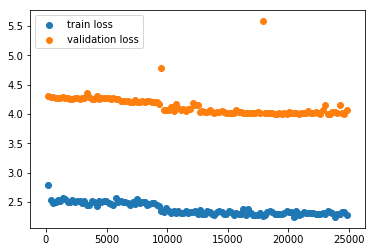

In [38]:
import matplotlib.pyplot as plt
plt.scatter(iterations, train_losses, label='train loss')
plt.scatter(iterations, val_losses, label='validation loss')
plt.legend()
plt.show()

Well, the loss IS decreasing at least a little bit.

In [27]:
import PeptideBuilder
test_protein = val_ids_remain[13]

In [28]:
test_angles_real = val_angles[13]
test_angles_pred = validation_preds[13].detach()

In [29]:
test_angles_real.shape

torch.Size([1, 1, 3, 431])

In [30]:
def make_pb_structure(seq_str, angles):
    psi = np.degrees(angles[0, :].tolist())
    omega = np.degrees(angles[1, :].tolist())
    phi = np.degrees(angles[2, :].tolist())
    structure = PeptideBuilder.make_structure(seq_str, phi, psi, omega)
    return(structure)

In [31]:
test_structure_real = make_pb_structure(val_proteins[test_protein]['primary'], test_angles_real[0, 0, :, :])

In [32]:
test_structure_pred = make_pb_structure(val_proteins[test_protein]['primary'], test_angles_pred[0, 0, :, :])

In [33]:
import Bio.PDB
def write_to_pdb(structure, prot_id, identifier):
    out = Bio.PDB.PDBIO()
    out.set_structure(structure)
    out.save(prot_id + identifier + ".pdb")

In [34]:
write_to_pdb(test_structure_real, test_protein, '_real')
write_to_pdb(test_structure_pred, test_protein, '_pred')

We can open the saved pdb files in pymol, align them and save the image.

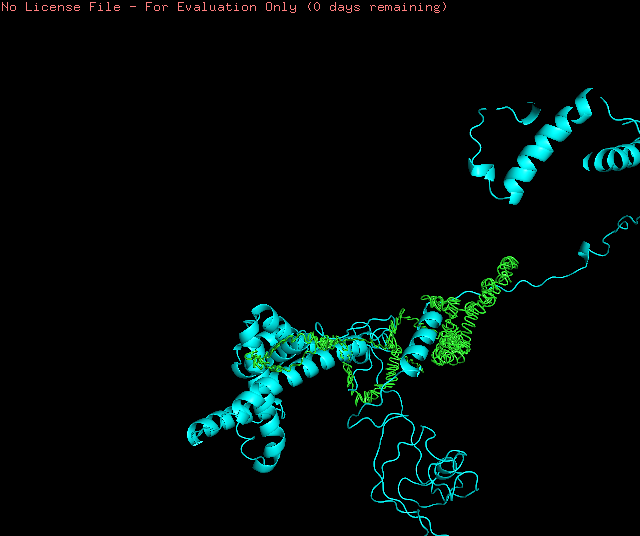

In [3]:
from IPython.display import Image 
im = Image(filename="/Users/Deathvoodoo/big_folders_docs/random/pred_real_aligned.png")
display(im)

Checking distribution of angles for the test protein.

In [36]:
print(test_angles_pred.max())
print(test_angles_real.max())

tensor(1.9369)
tensor(3.1415)


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


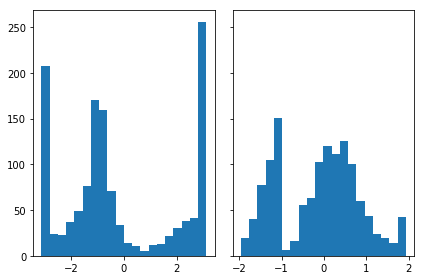

In [37]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
n_bins=20
axs[0].hist(test_angles_real.numpy().flatten(), bins=n_bins)
axs[1].hist(test_angles_pred.numpy().flatten(), bins=n_bins)
plt.show()

They're being squished too much inside a narrow interval.